In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_relative
%store -r Y_motion_relative
print(X_motion_relative.shape)
print(Y_motion_relative.shape)

(27032, 27)
(27032, 8)


# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL foot is swinging
idxs = np.where(X_motion_relative[:, 24] == 1)[0]
X_motion_relative_FR_RL = X_motion_relative[idxs]
Y_motion_relative_FR_RL = Y_motion_relative[idxs]

## Predict FL foot -> x

In [8]:
X_motion_relative_FR_RL.shape

(13712, 27)

In [9]:
X_motion_relative_FR_RL[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -4.92429697e-30, -1.14330159e-29,
        7.16981888e-03,  9.99974297e-01, -5.53546168e-14, -1.36752626e-12,
        1.85000000e-01,  1.35000000e-01, -3.39000000e-01,  1.86000000e-01,
       -1.35000000e-01, -3.39000000e-01, -2.77000000e-01,  1.35000000e-01,
       -3.41000000e-01, -2.78000000e-01, -1.34000000e-01, -3.42000000e-01,
        1.00000000e+00,  0.00000000e+00,  1.63241605e+09])

In [10]:
Y_motion_relative_FR_RL[0, :]

array([-0.012,  0.001,  0.02 ,  0.   ,  0.009,  0.001, -0.014, -0.002])

### Linear Regression

In [11]:
# Input
#X = np.hstack((X_motion_relative_FR_RL[:, :2], np.array([X_motion_relative_FR_RL[:, 5]]).T,
#               X_motion_relative_FR_RL[:, 6:8], np.array([X_motion_relative_FR_RL[:, 11]]).T,
#               np.array([X_motion_relative_FR_RL[:, 12]]).T, np.array([X_motion_relative_FR_RL[:, 15]]).T))
#X = np.hstack((X_motion_relative_FR_RL[:, :2], np.array([X_motion_relative_FR_RL[:, 5]]).T,
#               np.array([X_motion_relative_FR_RL[:, 12]]).T, np.array([X_motion_relative_FR_RL[:, 15]]).T))
X = np.hstack((X_motion_relative_FR_RL[:, :2],
               np.array([X_motion_relative_FR_RL[:, 5]]).T,
               X_motion_relative_FR_RL[:, 12:14],
               X_motion_relative_FR_RL[:, 15:17],
               X_motion_relative_FR_RL[:, 18:20],
               X_motion_relative_FR_RL[:, 21:23]))

# Target
Y = np.array([Y_motion_relative_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_x = LinearRegression()

# Fit the model
model_fr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9891085897393074
RMSE:  0.005122463035010341
The lowest error is:  1.1728460179716294e-06
The highest error is:  0.05458661132070494
The avg. error is:  0.0025918485979950674


In [12]:
model_fr_relative_swinging_x.intercept_

array([0.12855594])

Text(0, 0.5, 'Predictions')

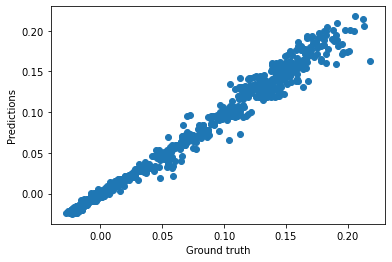

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [17]:
%store model_fr_relative_swinging_x

Stored 'model_fr_relative_swinging_x' (LinearRegression)


In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [19]:
# Save model
joblib.dump(model_fr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_x.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_x.sav']

### Predict FL foot -> y

In [14]:
# Input
#X = np.hstack((X_motion_relative_FR_RL[:, :2], np.array([X_motion_relative_FR_RL[:, 5]]).T,
#               X_motion_relative_FR_RL[:, 6:8], np.array([X_motion_relative_FR_RL[:, 11]]).T,
#               np.array([X_motion_relative_FR_RL[:, 12]]).T, np.array([X_motion_relative_FR_RL[:, 15]]).T))
#X = np.hstack((X_motion_relative_FR_RL[:, :2], np.array([X_motion_relative_FR_RL[:, 5]]).T,
#               np.array([X_motion_relative_FR_RL[:, 12]]).T, np.array([X_motion_relative_FR_RL[:, 15]]).T))
X = np.hstack((X_motion_relative_FR_RL[:, :2],
               np.array([X_motion_relative_FR_RL[:, 5]]).T,
               X_motion_relative_FR_RL[:, 12:14],
               X_motion_relative_FR_RL[:, 15:17],
               X_motion_relative_FR_RL[:, 18:20],
               X_motion_relative_FR_RL[:, 21:23]))

# Target
Y = np.array([Y_motion_relative_FR_RL[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_y = LinearRegression()

# Fit the model
model_fr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9862502591426917
RMSE:  0.005429693768161038
The lowest error is:  1.1810702557069064e-06
The highest error is:  0.05297509857776933
The avg. error is:  0.003031548282692573


In [15]:
model_fr_relative_swinging_y.intercept_

array([-0.31804721])

Text(0, 0.5, 'Predictions')

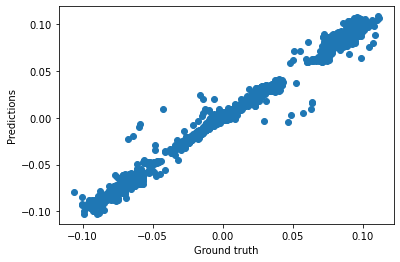

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [22]:
%store model_fr_relative_swinging_y

Stored 'model_fr_relative_swinging_y' (LinearRegression)


In [23]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [24]:
# Save model
joblib.dump(model_fr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_y.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_y.sav']